## Phosphatidylcholine (34:0) 

In [10]:
import sys,os,glob

In [11]:
sys.path.append('/home/simon/git/pymzm')
sys.path.append('/home/simon/git/mass-spec-utils')

In [96]:
condition = 1
ion_mode = 'Pos'

In [97]:
mzml_folder = '/home/simon/data/lipid_files/lipid_files/Condition_{}/{}/'.format(condition,ion_mode)
pp_folder = os.path.join(mzml_folder,'picked_peaks')

In [98]:
mzml_file_list = glob.glob(os.path.join(mzml_folder,'*.mzML'))
mzml_pp = []
for m in mzml_file_list:
    final_part = m.split(os.sep)[-1]
    pp_name = final_part.split('.')[0] + '_box.csv'
    mzml_pp.append((m,os.path.join(pp_folder,pp_name)))
    
for m,p in mzml_pp:
    print(m,p)

/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/0_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/0_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/48_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/48_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/96_pp_d20_.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/96_pp_d20__box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/24_pp_s3_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/24_pp_s3_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/72_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/72_pp_d20_pos_1_box.csv
/home/simon/data/lipid_files/lipid_files/Condition_1/Pos/8_pp_d20_pos_1.mzML /home/simon/data/lipid_files/lipid_files/Condition_1/Pos/picked_peaks/8_pp_d2

In [99]:
from ms2_matching import load_picked_boxes,MZMLFile

In [100]:
all_boxes = {}
for m,p in mzml_pp:
    all_boxes[p] = load_picked_boxes(p)

In [101]:
all_mzml_file_obj = {}
for m,p in mzml_pp:
    all_mzml_file_obj[p] = MZMLFile(m)

Loaded 1968 scans
Loaded 1968 scans
Loaded 1967 scans
Loaded 1968 scans
Loaded 1968 scans
Loaded 1968 scans


Add chromatograms back to the peaks

In [102]:
from chromatograms import add_chromatograms_to_boxes
for p in all_boxes:
    add_chromatograms_to_boxes(all_boxes[p],all_mzml_file_obj[p])
    

In [103]:
from chromatograms import cluster_box_chromatograms
all_groups = {}
for p in all_boxes:
    all_groups[p],_ = cluster_box_chromatograms(all_boxes[p],threshold = 0.8,max_mz_diff = 10)

In [104]:
def find_boxes(boxes,mz,rt_in_seconds,mz_tol = 0.01,rt_tol = 10):
    sub_boxes = list(filter(lambda x: abs(x.mz - mz) <= mz_tol and 
                            abs(x.rt_in_seconds - rt_in_seconds) <= rt_tol,boxes))
    return sub_boxes

In [120]:
from molmass import Formula
f = Formula('C42H84NO8P')
from adduct_rules import AdductTransformer
at = AdductTransformer()
if ion_mode == 'Pos':
    phosp_mz = at.mass2ion(f.isotope.mass,'[M+H]+')
else:
    phosp_mz = at.mass2ion(f.isotope.mass,'[M-H]-')
phosp_rt = 588
print(phosp_mz,phosp_rt)


762.6007321188208 588


In [114]:
all_phosp = {}
for p in all_boxes:
    l = find_boxes(all_boxes[p],phosp_mz,phosp_rt,rt_tol = 50)
    assert len(l) == 1,print(len(l))
    l = l[0]
    # find the group
    for g in all_groups[p]:
        if l in g:
            break
    all_phosp[p] = (l,g)

0


AssertionError: None

In [75]:
import pylab as plt
%matplotlib inline

In [76]:
# order files by time
ordered_files = list(all_boxes.keys())
ordered_files.sort(key = lambda x: int(x.split(os.sep)[-1].split('_')[0]))


4
4
4
6
5
6


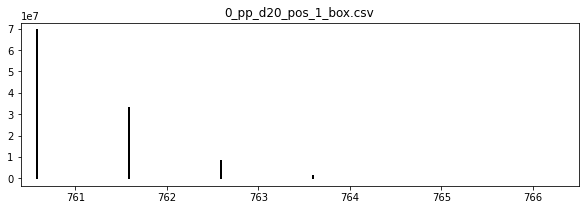

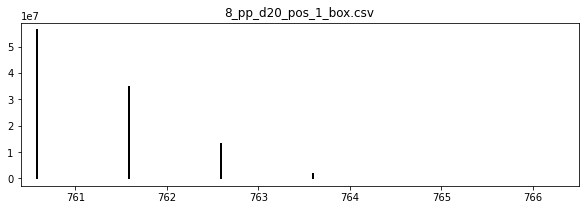

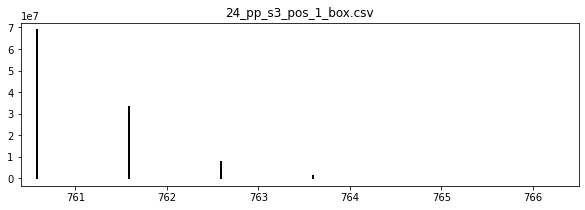

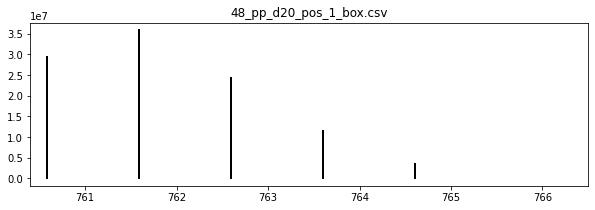

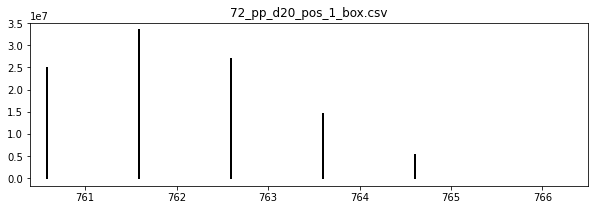

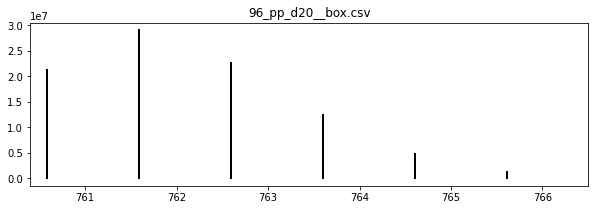

In [77]:
for f in ordered_files:
    plt.figure(figsize=(10,3))
    b,g = all_phosp[f]
    print(len(g))
    for box in g:
        plt.plot([box.mz,box.mz],[0,box.height],'k',linewidth=2)
    plt.xlim([760.4,766.5])
    plt.title(f.split(os.sep)[-1])

761.59345566673


In [118]:
print(f.spectrum())

Relative mass    Fraction %      Intensity
761.59346         61.594819     100.000000
762.59683         28.987901      47.062240
763.59987          7.682000      12.471828
764.60277          1.475895       2.396135
765.60558          0.226528       0.367770
766.60833          0.029231       0.047457
767.61105          0.003271       0.005311
768.61374          0.000324       0.000526
769.61647          0.000028       0.000046
770.61951          0.000002       0.000003
771.62282          0.000000       0.000000
